# Derivatives of $\theta$ and $\phi$


### Setup


In [1]:
import torch
from torch_harmonics.sht import RealSHT
from torch_harmonics.sht import InverseRealVectorSHT
import matplotlib.pyplot as plt
from torch_harmonics.plotting import plot_sphere

Let's define an example function $f = sin(\theta)cos(\phi)$, with derivatives with respect to $\theta$ and $\phi$: $f^*_{\theta}$ and $f^*_{\phi}$

In [2]:
# the function f(theta, phi) is the function we want to differentiate
def f(theta, phi):
    return torch.sin(theta) * torch.cos(phi)

def f2(theta, phi):
    return torch.cos(2*theta) * torch.sin(0.5*phi)

# nft(theta, phi) is the derivative of f with respect to theta -> f*_theta
def nft(theta, phi):
    return torch.cos(theta) * torch.cos(phi)

# nfp(theta, phi) is the derivative of f with respect to phi -> f*_phi
def nfp(theta, phi):
    return -torch.sin(theta) * torch.sin(phi)


Here we define a grid of $\theta$ and $\phi$ values and we evaluate the functions for each grid point

In [3]:
# Create a grid of theta and phi values
n_theta, n_phi = 128, 256
theta = torch.linspace(0, torch.pi, n_theta)
phi = torch.linspace(0, 2 * torch.pi, n_phi)
theta_grid, phi_grid = torch.meshgrid(theta, phi, indexing='ij')

# Evaluate the function on the grid for f, nft and nfp 
f_grid = f(theta_grid, phi_grid)
f_grid2 = f2(theta_grid, phi_grid)
nft_grid = nft(theta_grid, phi_grid) 
nfp_grid = nfp(theta_grid, phi_grid)


### Computation of the gradient

A convenient approach to the computation of the derivatives along $\theta$ and $\phi$ is to compute the Spherical Harmonic Transform (SHT) of the function we want to differentiate and then apply the Inverse Vector Spherical Harmonic Transform (IVSHT) to get $\nabla f$. We can then proceed to read $\partial f / \partial \theta$ and $\partial f / \partial \phi$ from the first and second component.



In [4]:
lmax = 5
sh_coeffs = RealSHT(n_theta, n_phi, lmax=lmax)(f_grid)

# We need to adapt the output of the SHT to be a vector field
vector_coeffs = torch.zeros(2, sh_coeffs.shape[0], sh_coeffs.shape[1], dtype=sh_coeffs.dtype)
vector_coeffs[0] = sh_coeffs 

nabla_f = InverseRealVectorSHT(n_theta, n_phi, lmax=lmax)(vector_coeffs)

# Since from IVSHT we get 1/sin(theta) * d/dphi, we need to multiply by sin(theta) to get the correct gradient
nabla_f[1] = nabla_f[1] * torch.sin(theta_grid)

print(f"Vector coefficients shape: {vector_coeffs.shape}")  # Should be (2, lmax, mmax)
print(f"Gradient field shape: {nabla_f.shape}")  # Should be (2, n_theta, n_phi)


Vector coefficients shape: torch.Size([2, 5, 129])
Gradient field shape: torch.Size([2, 128, 256])


### Plotting

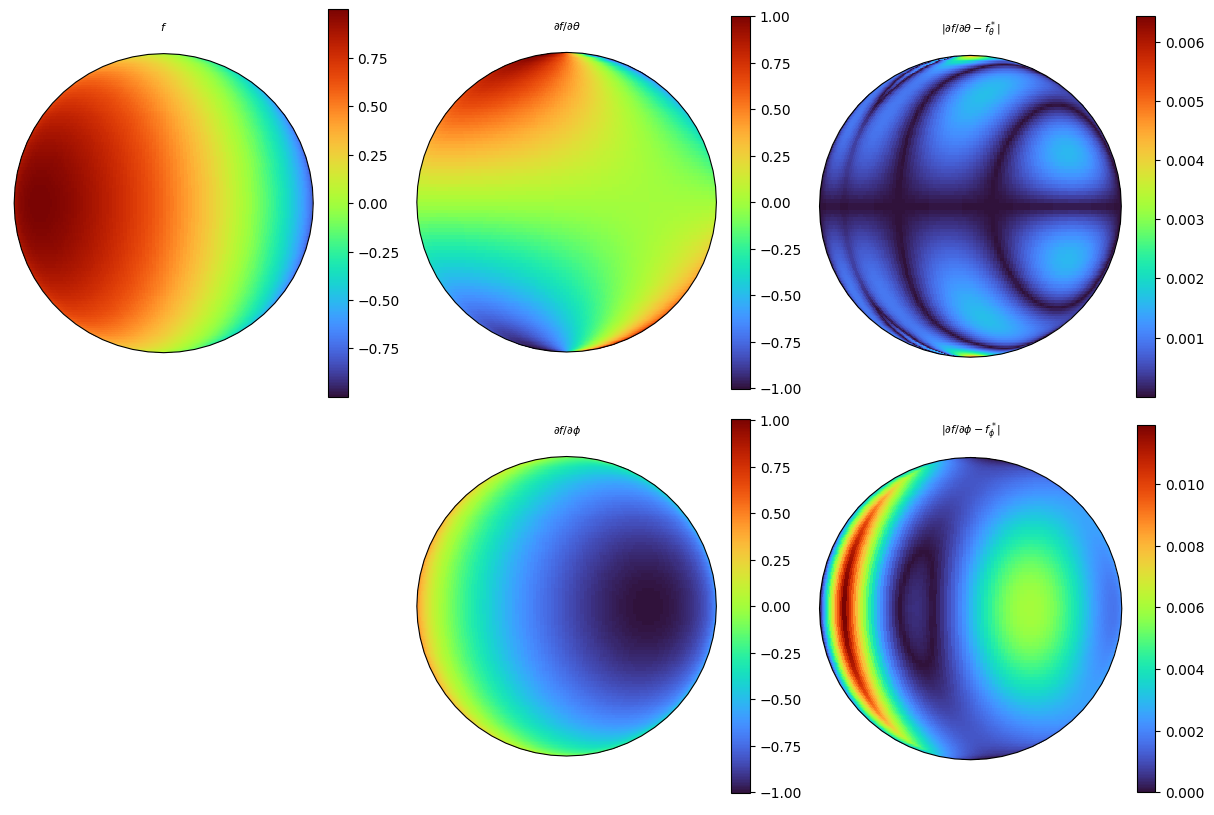

In [5]:
fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(2, 3)
clat, clon = 0, 56
plot_sphere(f_grid,   fig=subfigs[0, 0], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$f$")
plot_sphere(nabla_f[0],   fig=subfigs[0, 1], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"${\partial f } / {\partial \theta}$")
plot_sphere(nabla_f[1],   fig=subfigs[1, 1], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"${\partial f } / {\partial \phi}$")
plot_sphere(torch.abs(nabla_f[0] - nft_grid), fig=subfigs[0, 2], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$|{\partial f }/{\partial \theta} - f^*_{\theta}|$")
plot_sphere(torch.abs(nabla_f[1] - nfp_grid), fig=subfigs[1, 2], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$|{\partial f }/{\partial \phi} - f^*_{\phi}|$")
plt.show()

# W11 Loss

In [6]:
from torch_harmonics.examples.losses import W11LossS2, W11LossS2_v2

In [7]:
f_grid_extra = f_grid + 0.01*f_grid2
img_size = f_grid.shape
loss_w11 = W11LossS2(nlat=img_size[0], nlon=img_size[1], grid="equiangular")
loss_w11_v2 = W11LossS2_v2(nlat=img_size[0], nlon=img_size[1], grid="equiangular")
f_grid_loss = loss_w11._compute_loss_term(f_grid,f_grid_extra)
f_grid_loss_v2 = loss_w11_v2._compute_loss_term(f_grid,f_grid_extra)

In [8]:
f_grid.shape, f_grid_loss.shape

(torch.Size([128, 256]), torch.Size([128, 256]))

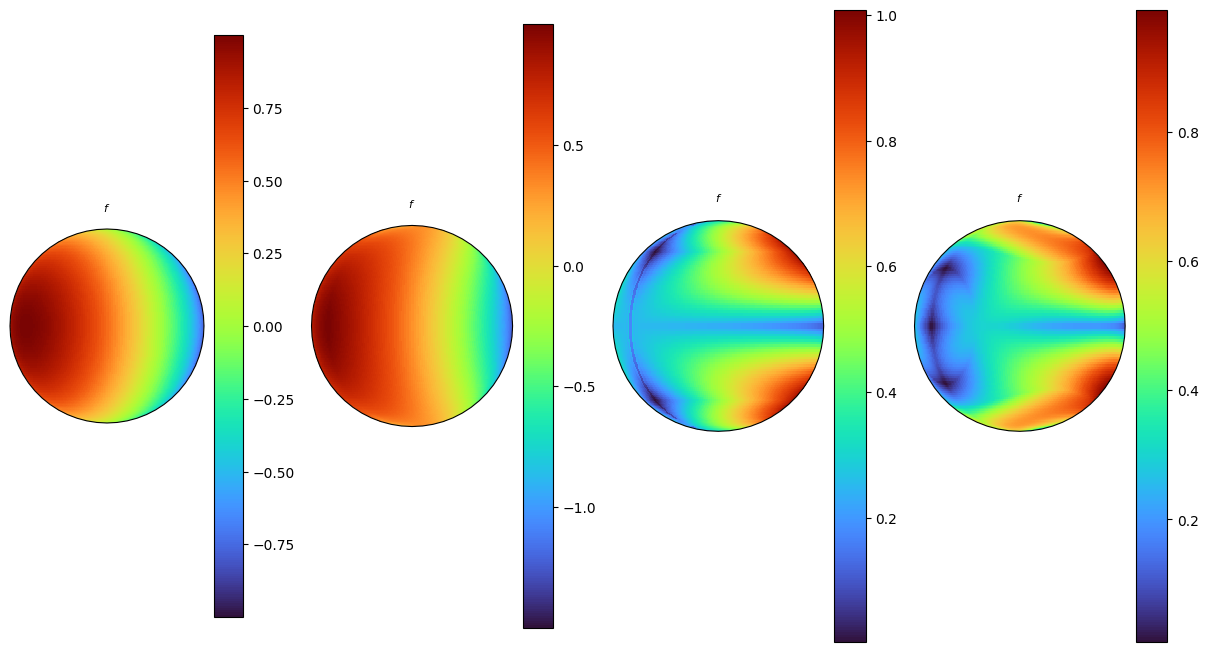

In [9]:
f_grid_extra = f_grid + 0.5*f_grid2
img_size = f_grid.shape
loss_w11 = W11LossS2(nlat=img_size[0], nlon=img_size[1], grid="equiangular")
loss_w11_v2 = W11LossS2_v2(nlat=img_size[0], nlon=img_size[1], grid="equiangular")
f_grid_loss = loss_w11._compute_loss_term(f_grid,f_grid_extra)
f_grid_loss_v2 = loss_w11_v2._compute_loss_term(f_grid,f_grid_extra)
fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(1,4)
clat, clon = 0, 56
plot_sphere(f_grid,   fig=subfigs[0], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$f$")
plot_sphere(f_grid_extra,   fig=subfigs[1], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$f$")
plot_sphere(f_grid_loss,   fig=subfigs[2], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$f$")
plot_sphere(f_grid_loss_v2,   fig=subfigs[3], central_latitude=clat, central_longitude=clon, projection="orthographic", cmap="turbo", colorbar=True, title=r"$f$")


In [10]:
loss_w11(f_grid,f_grid_extra), loss_w11_v2(f_grid,f_grid_extra)

(tensor(0.5234), tensor(0.5334))